In [94]:
import numpy as np
import pandas as pd
from shutil import copyfile
from astropy.cosmology import Planck13 as cosmo
import fsps
from matplotlib import gridspec
import matplotlib as mpl
from astropy.io import fits
from astropy import wcs
from astropy.table import Table
from sim_engine import Scale_model
from spec_tools import Source_present, Oldest_galaxy, Sig_int, Smooth, Rescale_sfh, lbt_to_z, boot_to_posterior, age_to_z, Posterior_spec
from spec_stats import Smooth, Highest_density_region
from spec_id import *
from spec_stats import Highest_density_region, Linear_fit
from spec_exam import Gen_spec
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, interp2d
from glob import glob
import seaborn as sea
import os
from grizli import multifit
from grizli import model
from sim_engine import forward_model_grism

import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
R = robjects.r
pandas2ri.activate()

from time import time
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.0, as_cmap=True)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### set home for files
hpath = os.environ['HOME'] + '/'

if hpath == '/Users/Vince.ec/':
    dpath = '/Volumes/Vince_research/Data/' 
    
else:
    dpath = hpath + 'Data/' 

In [69]:
morph_db = pd.read_pickle('../dataframes/fitdb/tabfitdb.pkl')

inout = []
for i in morph_db.index:
    for ii in range(len(morph_db.zgrism_hci[i])//2):
        if morph_db.zgrism_hci[i][2*ii] <= morph_db.zgrism[i] <= morph_db.zgrism_hci[i][2*ii+1]:
            if(morph_db.zgrism_hci[i][2*ii+1] - morph_db.zgrism_hci[i][2*ii]) /( 2 * (1 + morph_db.zgrism[i])) < 0.01:
                inout.append('i')
            else:
                inout.append('o')
        
morph_db['inout'] = inout
morph_db = morph_db.query('inout == "i" and n_f < 3 and Re < 20')

mdb = morph_db.query('n_f < 3 and lmass >= 10.5')
mdbMC = morph_db.query('n_f < 3 and zgrism <= 2 and lmass >= 10.5')
mdbMC2 = morph_db.query('n_f < 3 and lmass >= 11.0')
mdbG = morph_db.query('n_f < 2 and lmass >= 10.5')


In [21]:
GSD_X = Table.read('../data/clear_gdsxray.dat', format = 'ascii').to_pandas()
GND_X = Table.read('../data/clear_gdnxray.dat', format = 'ascii').to_pandas()

In [26]:
GSD_X = GSD_X.query('Xclass == "AGN"')
GND_X = GND_X.query('Xclass == "AGN"')

In [43]:
all_phot = glob('../phot/*npy')

In [44]:
fields = [os.path.basename(U).split('_')[0] for U in all_phot]
galaxy = [int(os.path.basename(U).split('_')[1]) for U in all_phot]


In [51]:
IDS = morph_db.id.values

outgals = []
outfields = []
for i in range(len(galaxy)):
    if galaxy[i] not in IDS:
        outgals.append(galaxy[i])
        outfields.append(fields[i])

In [58]:
IDS = GND_X.ID.values

for i in range(len(outfields)):
    if outfields[i][1] == 'N':
        if outgals[i] not in IDS:
            print(outgals[i])
print('=============')           
            
IDS = GSD_X.ID.values

for i in range(len(outfields)):
    if outfields[i][1] == 'S':
        if outgals[i] in IDS:
            print(outgals[i])

21618
22571
21427
33780
26544
12543
37343
11245
21896
22184
17735
22633
31397
42113
44725
42915
38472
35046
41886
39364
43114
23421
42820
39825
25641
42778
26915


In [59]:
GNSNR = pd.read_pickle('../dataframes/galaxy_frames/GN_cnd.pkl')
GSSNR = pd.read_pickle('../dataframes/galaxy_frames/GS_cnd.pkl')

In [68]:
IDS = GND_X.ID.values

for i in GNSNR.index:
    if GNSNR.id[i] not in IDS and GNSNR.X_AGN[i] == 'AGN':
        print(GNSNR.id[i], GNSNR.X_AGN[i])
        
    if GNSNR.id[i] in IDS and GNSNR.X_AGN[i] == '---':
        print(GNSNR.id[i], GNSNR.X_AGN[i])
print('=============')           
            
IDS = GSD_X.ID.values

for i in GSSNR.index:
    if GSSNR.id[i] not in IDS and GSSNR.X_AGN[i] == 'AGN':
        print(GSSNR.id[i], GSSNR.X_AGN[i])
        
    if GSSNR.id[i] in IDS and GSSNR.X_AGN[i] == '---':
        print(GSSNR.id[i], GSSNR.X_AGN[i])

14140 ---
23104 ---
35469 ---
37232 ---
37813 ---
29928 AGN
30144 AGN
45789 ---


# plot phots

In [154]:
def Roll_bin_stat(X,Y,E,bin_size):
    W = 1/E ** 2
    Y = Y[np.argsort(X)]
    W = W[np.argsort(X)]
    X = X[np.argsort(X)]
    
    X_med = [] ; X_mean = [] ; binned_median = [] ; binned_wmean = [] ; binned_err = []

    i=0
    low_lim = X[i]
    while low_lim < max(X):
        IDX = [U for U in range(len(X)) if low_lim <= X[U] < low_lim + bin_size]
        X_med.append(np.median(X[IDX]))
        X_mean.append(np.median(low_lim + bin_size / 2))
        binned_median.append(np.median(Y[IDX]))
        binned_wmean.append(np.sum(Y[IDX] * W[IDX]) / (np.sum(W[IDX])))
        binned_err.append(1 / np.sqrt(np.sum(W[IDX])))
        i+=1
        low_lim = X[i]
    return np.array(X_med), np.array(X_mean), np.array(binned_median), np.array(binned_wmean) , np.array(binned_err)

def Smooth(x,f,bw):
    ksmooth = importr('KernSmooth')

    ### select bandwidth
    H = ksmooth.dpik(x)
    
    if bw == 'none':
        bw = H
    
    fx = ksmooth.locpoly(x,f,bandwidth = bw)
    X = np.array(fx[0])
    iFX = np.array(fx[1])
    return interp1d(X,iFX)(x)

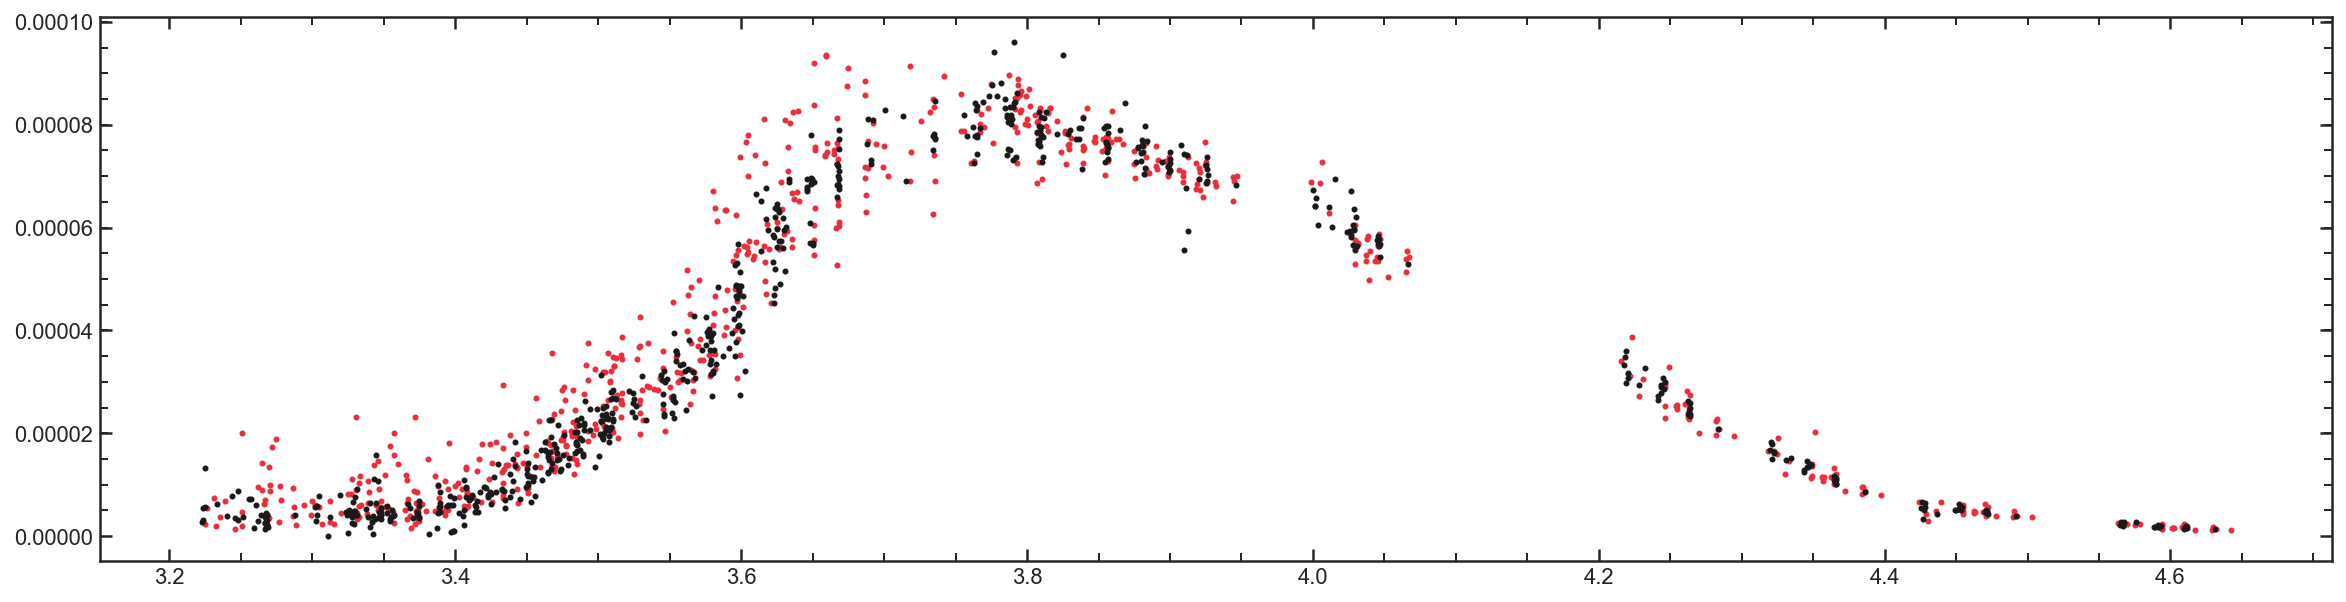

In [243]:
plt.figure(figsize=[20,5])

PWV = []
PER = []
PFL = []

for ID in mdb.query('z_50 < 3.26 and 0.8 < zgrism < 1.2').index:
    pwv,pfl,per,pnum = np.load('../phot/{0}_{1}_phot.npy'.format(mdb.field[ID], mdb.id[ID]))
    
    pwv = pwv[pfl > 0] 
    per = per[pfl > 0] 
    pfl = pfl[pfl > 0]
    
    pfl = pfl[np.argsort(pwv)]
    per = per[np.argsort(pwv)]
    pwv = pwv[np.argsort(pwv)]
        
    norm = np.trapz(pfl,pwv/ (1 +mdb.zgrism[ID] ))
    
    PWV.extend(pwv / (1 +mdb.zgrism[ID] ))
    PER.extend(per/norm)
    PFL.extend(pfl/norm)
    
PWV = np.array(PWV)
PFL = np.array(PFL)
PER = np.array(PER)

wmed1,wmn1,pmed1,pmn1,perr1 = Roll_bin_stat(PWV,PFL,PER, bin_size=200)

plt.plot(np.log10(PWV),PFL, 'o', ms=2, color='#EA2E3B', zorder = 2)
# plt.plot(wmn1,Smooth(wmn1,pmed1,0.001), color='#EA2E3B')

PWV = []
PER = []
PFL = []

for ID in mdb.query('z_50 > 3.26 and 0.8 < zgrism < 1.2').index:
    pwv,pfl,per,pnum = np.load('../phot/{0}_{1}_phot.npy'.format(mdb.field[ID], mdb.id[ID]))
    
    pwv = pwv[pfl > 0] 
    per = per[pfl > 0] 
    pfl = pfl[pfl > 0]
    
    pfl = pfl[np.argsort(pwv)]
    per = per[np.argsort(pwv)]
    pwv = pwv[np.argsort(pwv)]
        
    norm = np.trapz(pfl,pwv/ (1 +mdb.zgrism[ID] ))
    
    PWV.extend(pwv / (1 +mdb.zgrism[ID] ))
    PER.extend(per/norm)
    PFL.extend(pfl/norm)
    
PWV = np.array(PWV)
PFL = np.array(PFL)
PER = np.array(PER)

    
wmed2,wmn2,pmed2,pmn2,perr2 = Roll_bin_stat(PWV,PFL,PER, bin_size=200)

plt.plot(np.log10(PWV),PFL, 'o', ms=2, color='k', zorder = 2)
# plt.plot(wmn2,Smooth(wmn2,pmed2,0.005), 'k')

(1000, 10000)

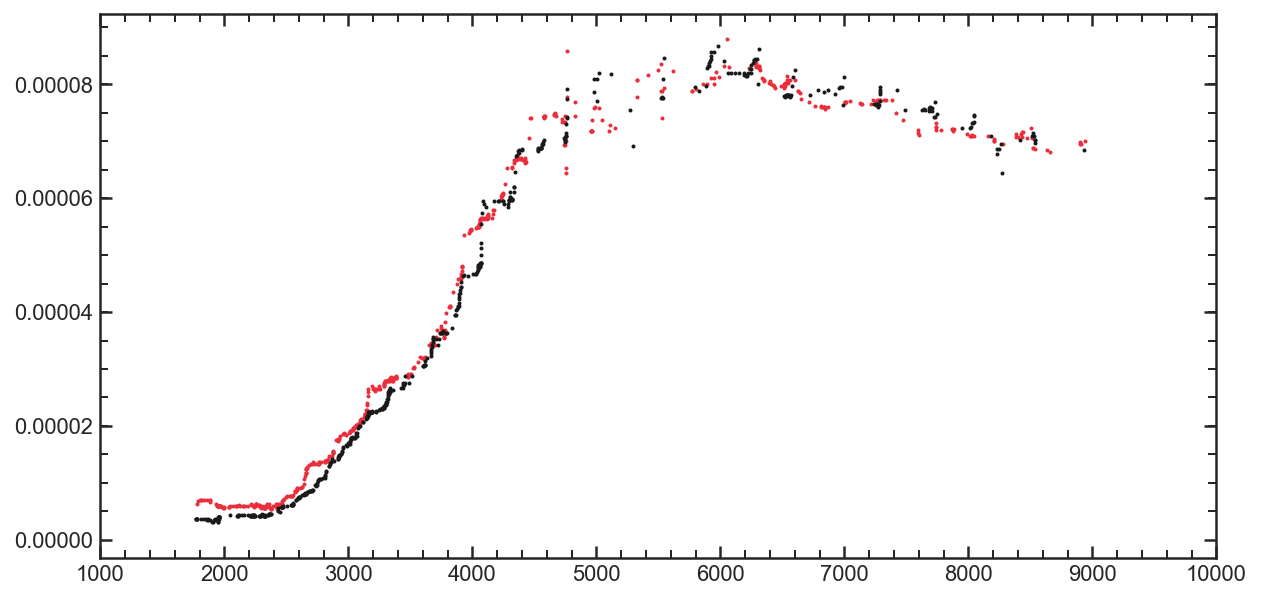

In [244]:
plt.figure(figsize=[10,5])

plt.plot(wmn1,pmed1, 'o', color='#EA2E3B', ms = 1)
plt.plot(wmn2,pmed2,  'o', color='k', ms = 1)
plt.xlim(1000,10000)
# plt.ylim(-14.5,-8)

In [236]:
wmn2

array([3.11324513, 3.13666766, 3.14900609, ..., 4.7111696 , 4.71131081,
       4.73118648])